In [134]:
import pandas as pd
import os
import datetime
to_datetime = lambda d: pd.to_datetime(d, format='%d/%m/%Y')

def skip_month(date, day):
    return to_datetime(day + '/' +
               ('1' if int(date.month)==12 else str(int(date.month) + 1)) + '/' +
               (str(int(date.year)+1) if int(date.month)==12 else str(int(date.year))))

In [2]:
fiis_names = [line.rstrip('\n') for line in open('../cotacoes/carteiras/IFIX.sa.txt')]
fiis_dataFrame = pd.DataFrame()
dir = "../cotacoes/dados/b3/cotacoes_diarias/"

for fn in fiis_names:
    file_name = dir + fn + '.csv'
    try:
        fiis_dataFrame = fiis_dataFrame.merge(pd.read_csv(file_name, converters={'date': to_datetime}).set_index('date').add_suffix('_'+fn), how='outer', left_index=True, right_index=True)
    except:
        print(file_name + ' not found!')
    
fiis_dataFrame.tail()

../cotacoes/dados/b3/cotacoes_diarias/ABCP11.sa.csv not found!


,open_BPFF11.sa,high_BPFF11.sa,low_BPFF11.sa,close_BPFF11.sa,neg_BPFF11.sa,vol_BPFF11.sa,open_ALZR11.sa,high_ALZR11.sa,low_ALZR11.sa,close_ALZR11.sa,...,low_XPCM11.sa,close_XPCM11.sa,neg_XPCM11.sa,vol_XPCM11.sa,open_XPML11.sa,high_XPML11.sa,low_XPML11.sa,close_XPML11.sa,neg_XPML11.sa,vol_XPML11.sa
date,,,,,,,,,,,,,,,,,,,,,
2019-08-22,104.99,105.00,103.61,105.00,174.0,27388747.0,105.70,105.89,105.30,105.60,...,56.21,56.27,256.0,28983493.0,111.25,111.69,111.11,111.69,1328.0,361339304.0
2019-08-23,104.98,104.98,103.58,103.58,191.0,37688776.0,105.59,105.59,104.55,105.00,...,56.05,56.61,408.0,45688163.0,111.69,111.79,110.13,110.85,1967.0,506810955.0
2019-08-26,103.60,105.00,102.84,102.84,380.0,87634430.0,105.01,105.02,104.10,104.49,...,56.20,56.25,339.0,50694398.0,110.90,111.45,110.12,110.94,1744.0,370917899.0
2019-08-27,103.00,103.99,102.13,103.16,140.0,18323894.0,104.70,105.47,103.55,104.93,...,56.10,56.10,336.0,59351092.0,110.93,110.93,110.12,110.75,1424.0,454071646.0
2019-08-28,103.20,104.25,102.14,103.75,407.0,96659814.0,104.80,105.69,104.30,104.60,...,56.20,56.89,346.0,62076364.0,110.60,111.45,110.02,111.45,1090.0,356731930.0


In [137]:
# splits data to be used

for day_scan in range(27):

    day = str(day_scan+1)
    
    start = to_datetime(day + '/08/2018')
    fiis = fiis_dataFrame[fiis_dataFrame.index >= start]
    fiis = fiis.dropna(axis=1, how='any')

    #fiis.plot(figsize=(15,6))
    #fiis.tail()

    fiis_closing_key = []

    for key in fiis.keys():
        if(key.startswith('close')):
            fiis_closing_key.append(key)

    # corrects inplit and splits

    for fk in fiis_closing_key:
        multiplier = 1
        price_list = list(range(len(fiis[fk])))[:-1]
        price_list.reverse()
        #print(price_list)
        for price in price_list:
            ratio = fiis[fk][price]/fiis[fk][price+1]/multiplier
            if ratio >= 2 or ratio <= 1/2:
                multiplier *= ratio #round to nearest integer
                #rint(str(fk) + ' ' + str(price))
                #rint(multiplier)
            fiis[fk][price] /= multiplier

    # keys para tickers ??

    fiis_per_month = 3
    balance = 1
    wallet = [] # fiis_per_month
    # wallet[x] = asset name

    skip = datetime.timedelta(days=1)

    variation = [] #TIRAR ??
    fiis_to_buy = []

    past = start
    while not past in fiis.index and past < fiis.index[-1]:
            past = past + skip

    current = skip_month(past, day)
    while current < fiis.index[-1]:
        while not current in fiis.index and current < fiis.index[-1]:
            current = current + skip

        current_data = fiis.loc[current]
        past_data = fiis.loc[past]

        # sells old assets
        monthly_balance = 1
        while len(wallet):
            to_sell = wallet.pop()
            monthly_balance += (current_data[to_sell] - past_data[to_sell]) / past_data[to_sell] / fiis_per_month # avarage gain of the month

        balance *= monthly_balance # multiplies by month gain        


        # finds new assets to buy
        # calculates variations
        variation = []
        for fk in fiis_closing_key:
            variation.append((current_data[fk] - past_data[fk])/past_data[fk])

        # picks maximum drops
        for fpm in range(fiis_per_month):
            index = variation.index(min(variation))
            #print(str(variation[index]) + ' ' + str(fiis_closing_key[index]))
            variation[index] = 10000 # big value for elimination sake
            wallet.append(fiis_closing_key[index])

        #print(str(current.strftime('%d/%m/%Y')) + ' ' + str(balance))
        #print(wallet)
        #print('-----')
        past = current
        current = skip_month(current, day)
    print(day + ': ' + str(balance))

1: 1.2436528930241515
2: 1.261759527855988
3: 1.22746914604165
4: 1.2625702781678867
5: 1.1971763829881013
6: 1.2977084144284883
7: 1.454043093159204
8: 1.3304147759019493
9: 1.3428778617200823
10: 1.178205612979808
11: 1.3145417694569235
12: 1.3803556394265253
13: 1.491263630422297
14: 1.5275831938122446
15: 1.567972419491124
16: 1.353430596946967
17: 1.2606192919985548
18: 1.2892737793013143
19: 1.2114976067143752
20: 1.175633035428102
21: 1.1621519925948647
22: 1.254680387948515
23: 1.3261587474203187
24: 1.469753746223177
25: 1.3351970001721643
26: 1.282583683606077
27: 1.2610359926790096


In [45]:
print(current)
test = to_datetime('1' + '/' +
                   ('1' if int(current.month)==12 else str(int(current.month) + 1)) + '/' +
                   (str(int(current.year)+1) if int(current.month)==12 else str(int(current.year))))
print(test)

2016-08-01 00:00:00
2016-09-01 00:00:00


In [33]:
print(3 if 1==4 else 4)

4


In [228]:

fiis_dataFrameTest = pd.DataFrame()

test2 = pd.read_csv(dir + 'ALUP11.sa.csv', converters={'date': to_datetime}).set_index('date')
test2 = test2.add_prefix('oi')
print(test2.tail())

fiis_dataFrameTest = fiis_dataFrameTest.merge( test2, how='outer', left_index=True, right_index=True, suffixes=('', '2'))

print(fiis_dataFrameTest.tail())


            oiopen  oihigh  oilow  oiclose  oineg       oivol
date                                                         
2019-08-22   25.61   25.80  25.47    25.80   1868   787540300
2019-08-23   25.73   25.73  25.14    25.40   2088   955703900
2019-08-26   25.79   25.79  24.86    25.10   2317  1025724100
2019-08-27   25.20   25.49  24.76    24.99   2080  1261621400
2019-08-28   24.94   25.50  24.78    25.22   2518  1139040400
            oiopen  oihigh  oilow  oiclose  oineg       oivol
date                                                         
2019-08-22   25.61   25.80  25.47    25.80   1868   787540300
2019-08-23   25.73   25.73  25.14    25.40   2088   955703900
2019-08-26   25.79   25.79  24.86    25.10   2317  1025724100
2019-08-27   25.20   25.49  24.76    24.99   2080  1261621400
2019-08-28   24.94   25.50  24.78    25.22   2518  1139040400


In [41]:
#[['close_RNEW11', 385.0], ['close_KLBN11', 56.0], ['close_SULA11', 39.0]]
fiis['close_RNEW11.sa'].plot()

KeyError: 'close_RNEW11.sa'

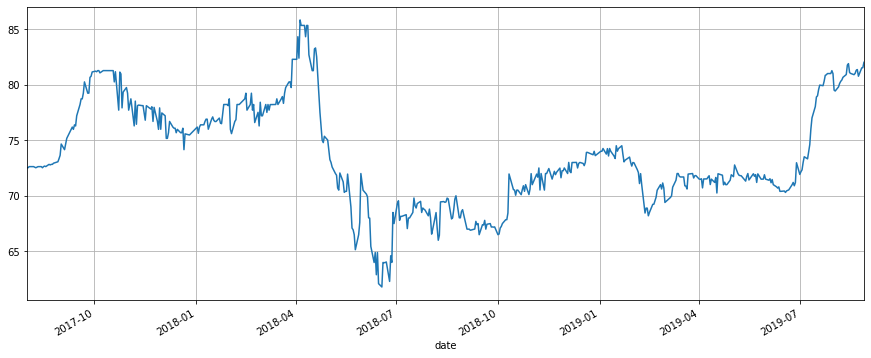

In [134]:
#[['close_FIGS11.sa', 31.0], ['close_HTMX11.sa', 14.0], ['close_RNGO11.sa', 24.0], ['close_BBRC11.sa', 14.0], ['close_FEXC11.sa', 19.0], ['close_XPCM11.sa', 21.0], ['close_FIIP11B.sa', 10.0], ['close_KNCR11.sa', 19.0], ['close_KNIP11.sa', 18.0], ['close_CPTS11B.sa', 20.0], ['close_BBPO11.sa', 14.0], ['close_JRDM11.sa', 28.0], ['close_CBOP11.sa', 27.0], ['close_SAAG11.sa', 16.0], ['close_KNRI11.sa', 13.0], ['close_NSLU11.sa', 9.0], ['close_CTXT11.sa', 478.0], ['close_BRCR11.sa', 19.0], ['close_BCRI11.sa', 18.0], ['close_CNES11.sa', 25.0]]
#fiis['close_CBOP11.sa'][170:180].plot(figsize=(15,6))
#fiis['close_CBOP11.sa'][170:180].plot(figsize=(15,6), grid='on')
fiis['close_CBOP11.sa'].plot(figsize=(15,6), grid='on')

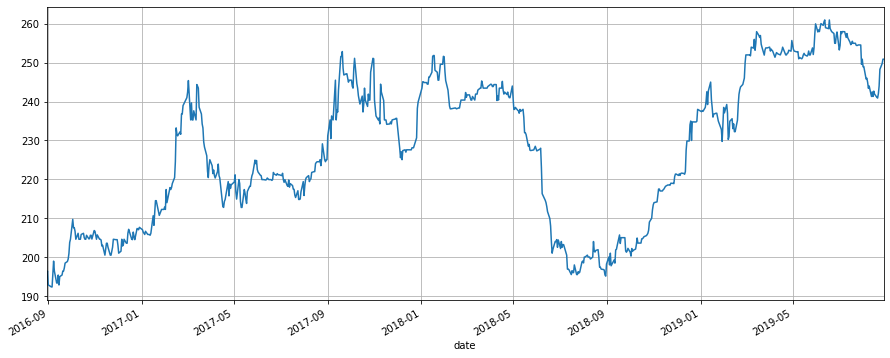

In [73]:
#[['close_BRCR11.sa', 10.0], ['close_CTXT11.sa', 17.0], ['close_XPCM11.sa', 11.0], ['close_BPFF11.sa', 11.0], ['close_BBFI11B.sa', 0.0]]
fiis['close_HGBS11.sa'].plot(figsize=(15,6), grid='on')

In [146]:
fiis_dataFrame.tail()

,open_BPFF11.sa,high_BPFF11.sa,low_BPFF11.sa,close_BPFF11.sa,neg_BPFF11.sa,vol_BPFF11.sa,open_ALZR11.sa,high_ALZR11.sa,low_ALZR11.sa,close_ALZR11.sa,...,low_XPCM11.sa,close_XPCM11.sa,neg_XPCM11.sa,vol_XPCM11.sa,open_XPML11.sa,high_XPML11.sa,low_XPML11.sa,close_XPML11.sa,neg_XPML11.sa,vol_XPML11.sa
date,,,,,,,,,,,,,,,,,,,,,
2019-08-22,104.99,105.00,103.61,105.00,174.0,27388747.0,105.70,105.89,105.30,105.60,...,56.21,56.27,256.0,28983493.0,111.25,111.69,111.11,111.69,1328.0,361339304.0
2019-08-23,104.98,104.98,103.58,103.58,191.0,37688776.0,105.59,105.59,104.55,105.00,...,56.05,56.61,408.0,45688163.0,111.69,111.79,110.13,110.85,1967.0,506810955.0
2019-08-26,103.60,105.00,102.84,102.84,380.0,87634430.0,105.01,105.02,104.10,104.49,...,56.20,56.25,339.0,50694398.0,110.90,111.45,110.12,110.94,1744.0,370917899.0
2019-08-27,103.00,103.99,102.13,103.16,140.0,18323894.0,104.70,105.47,103.55,104.93,...,56.10,56.10,336.0,59351092.0,110.93,110.93,110.12,110.75,1424.0,454071646.0
2019-08-28,103.20,104.25,102.14,103.75,407.0,96659814.0,104.80,105.69,104.30,104.60,...,56.20,56.89,346.0,62076364.0,110.60,111.45,110.02,111.45,1090.0,356731930.0
